<a href="https://colab.research.google.com/github/Saharsh2k5/Assignment4_ML/blob/main/ML_Assignment4_Q2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Implementing and comparing the following different KNN variants
LSH (1 marks)
KD-tree (1 marks)
Naive version of KNN (0.5 marks)

Vary dataset size N, number of dimensions D to do training and testing time and memory comparison for finding K nearest neighbours.


In [ ]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
import heapq
from collections import defaultdict
import matplotlib.pyplot as plt
np.random.seed(35)

class OptimizedKDTree:
    def __init__(self, data, max_samples_in_leaf=40):
        self.max_samples_in_leaf = max_samples_in_leaf
        self.tree = self._build_tree(data)

    def _build_tree(self, data, depth=0):
        if len(data) <= self.max_samples_in_leaf:
            return {'data': data, 'left': None, 'right': None, 'axis': None}

        axis = depth % data.shape[1]
        sorted_idx = np.argsort(data[:, axis])
        sorted_data = data[sorted_idx]
        median_idx = len(sorted_data) // 2
        median_point = sorted_data[median_idx]

        left_tree = self._build_tree(sorted_data[:median_idx], depth + 1)
        right_tree = self._build_tree(sorted_data[median_idx:], depth + 1)

        return {'point': median_point, 'left': left_tree, 'right': right_tree, 'axis': axis}

    def _query_recursive(self, node, query_point, heap, k):
        if node is None:
            return

        if 'data' in node:
            for point in node['data']:
                dist_sq = np.sum((query_point - point) ** 2)
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, point))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, point))
            return

        axis = node['axis']
        diff = query_point[axis] - node['point'][axis]

        primary_branch = node['left'] if diff < 0 else node['right']
        self._query_recursive(primary_branch, query_point, heap, k)

    def query(self, query_point, k=1):
        heap = []
        self._query_recursive(self.tree, query_point, heap, k)
        return sorted([(-d, p) for d, p in heap])

    def plot_tree(self, ax=None, node=None, x_min=0, x_max=1, y_min=0, y_max=1, depth=0):
        if ax is None:
            ax = plt.gca()

        if node is None:
            node = self.tree

        if node.get('data') is not None:
            return

        axis = node['axis']
        median_point = node['point']

        if axis == 0:
            ax.axvline(x=median_point[0], color='black', linestyle='--', lw=1)
            self.plot_tree(ax, node['left'], x_min, median_point[0], y_min, y_max, depth + 1)
            self.plot_tree(ax, node['right'], median_point[0], x_max, y_min, y_max, depth + 1)
        elif axis == 1:
            ax.axhline(y=median_point[1], color='black', linestyle='--', lw=1)
            self.plot_tree(ax, node['left'], x_min, x_max, y_min, median_point[1], depth + 1)
            self.plot_tree(ax, node['right'], x_min, x_max, median_point[1], y_max, depth + 1)

# LSH implementation
class LSH:
    np.random.seed(35)
    def __init__(self, num_hyperplanes, num_dimensions):
        self.num_hyperplanes = num_hyperplanes
        self.num_dimensions = num_dimensions + 1
        self.W = None
        self.hash_table = defaultdict(list)

    def fit(self, X):
        X = np.hstack([X,np.ones((X.shape[0], 1))])
        self.W = np.random.normal(0, 1, (self.num_dimensions, self.num_hyperplanes))
        hash_codes = self._compute_hash(X)

        for idx, hash_code in enumerate(hash_codes):
            bucket_key = tuple(hash_code)
            self.hash_table[bucket_key].append(idx)

        self.data = X

    def _compute_hash(self, X):
        H = np.dot(X, self.W)
        return np.sign(H).astype(int)

    def query(self, query_point, k=1):
        query_point_with_bias = np.append(query_point, 1)
        query_hash = tuple(self._compute_hash(query_point_with_bias.reshape(1, -1))[0])

        candidates = self.hash_table.get(query_hash, [])

        if not candidates:
            return [], []

        candidate_points = self.data[candidates, :-1]

        distances = euclidean_distances(candidate_points, query_point.reshape(1, -1)).flatten()

        nearest_indices = np.argsort(distances)[:k]
        return [candidates[i] for i in nearest_indices], distances[nearest_indices]

    def plot_hyperplanes(self, ax=None):
        if ax is None:
            ax = plt.gca()

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        for hyperplane in self.W.T:
            w1, w2 = hyperplane[:2]
            b = hyperplane[2]

            x_vals = np.linspace(x_min, x_max, 100)
            y_vals = (-w1 * x_vals - b) / w2

            ax.plot(x_vals, y_vals, linestyle='--', color='black', alpha=0.5)

def naive_knn(X, query, k=1):
    distances = euclidean_distances(X, query.reshape(1, -1)).flatten()
    indices = np.argsort(distances)[:k]
    return indices, distances[indices]


In [ ]:
import tracemalloc

def memory_usage(func, *args, **kwargs):
    tracemalloc.start()
    result = func(*args, **kwargs)
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, peak_memory / (1024 * 1024)

def generate_data(N, D):
    return np.random.rand(N, D)

np.random.seed(35)
def run_experiment(N, D, k_values, num_test_points):
    X_train = generate_data(N, D)
    X_test = generate_data(num_test_points, D)

    kdtree_model = OptimizedKDTree(X_train)
    lsh_model = LSH(num_hyperplanes=5, num_dimensions=D)
    lsh_model.fit(X_train)

    results = {}
    for k in k_values:
        total_query_time_kdtree = 0
        total_memory_kdtree = 0
        total_query_time_lsh = 0
        total_memory_lsh = 0
        total_query_time_naive = 0
        total_memory_naive = 0

        for query_point in X_test:
            # Measuring memory usage
            _, memory_kdtree = memory_usage(kdtree_model.query, query_point, k)
            total_memory_kdtree += memory_kdtree

            _, memory_lsh = memory_usage(lsh_model.query, query_point, k)
            total_memory_lsh += memory_lsh

            _, memory_naive = memory_usage(naive_knn, X_train, query_point, k)
            total_memory_naive += memory_naive

            # Measuring query times
            start_time = time.time()
            kdtree_model.query(query_point, k)
            total_query_time_kdtree += time.time() - start_time

            start_time = time.time()
            lsh_model.query(query_point, k)
            total_query_time_lsh += time.time() - start_time

            start_time = time.time()
            naive_knn(X_train, query_point, k)
            total_query_time_naive += time.time() - start_time

        results[k] = {
            'KD-Tree': {'memory': total_memory_kdtree / num_test_points,'time': total_query_time_kdtree / num_test_points},
            'LSH': {'memory': total_memory_lsh / num_test_points, 'time': total_query_time_lsh / num_test_points},
            'Naive': {'memory': total_memory_naive / num_test_points, 'time': total_query_time_naive / num_test_points},
        }
    return results


# Running the experiment with different dataset sizes and dimensions
dataset_sizes = [1000, 10000, 100000]
dimensions = [2, 10, 25]
k_values = [1, 5, 10]
num_test_points = 100
print(f"{'Dataset Size (N)':<20}{'Dimensions (D)':<15}{'K':<10}{'KD-Tree Memory (MB)':<20}{'LSH Memory (MB)':<20}{'Naive Memory (MB)':<20}{'KD-Tree Time (s)':<20}{'LSH Time (s)':<20}{'Naive Time (s)':<20}")
print("-" * 140)

for N in dataset_sizes:
    for D in dimensions:
        results=run_experiment(N, D, k_values, num_test_points)
        for k, res in results.items():
            kdtree_memory = res['KD-Tree']['memory']
            kdtree_time = res['KD-Tree']['time']
            lsh_memory = res['LSH']['memory']
            lsh_time = res['LSH']['time']
            naive_memory = res['Naive']['memory']
            naive_time = res['Naive']['time']
            print(f"{N:<20}{D:<15}{k:<10}{kdtree_memory:<20.6f}{lsh_memory:<20.6f}{naive_memory:<20.6f}{kdtree_time:<20.6f}{lsh_time:<20.6f}{naive_time:<20.6f}")


Dataset Size (N)    Dimensions (D) K         KD-Tree Memory (MB) LSH Memory (MB)     Naive Memory (MB)   KD-Tree Time (s)    LSH Time (s)        Naive Time (s)      
--------------------------------------------------------------------------------------------------------------------------------------------
1000                2              1         0.001335            0.029011            0.025791            0.000178            0.000447            0.000338            
1000                2              5         0.001801            0.028530            0.025791            0.000180            0.000448            0.000342            
1000                2              10        0.002510            0.028487            0.025791            0.000181            0.000440            0.000332            
1000                10             1         0.001382            0.049387            0.065351            0.000368            0.000764            0.000660            
1000                10       

Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature.

Also show the partitions in the 2d space. (0.5 marks)

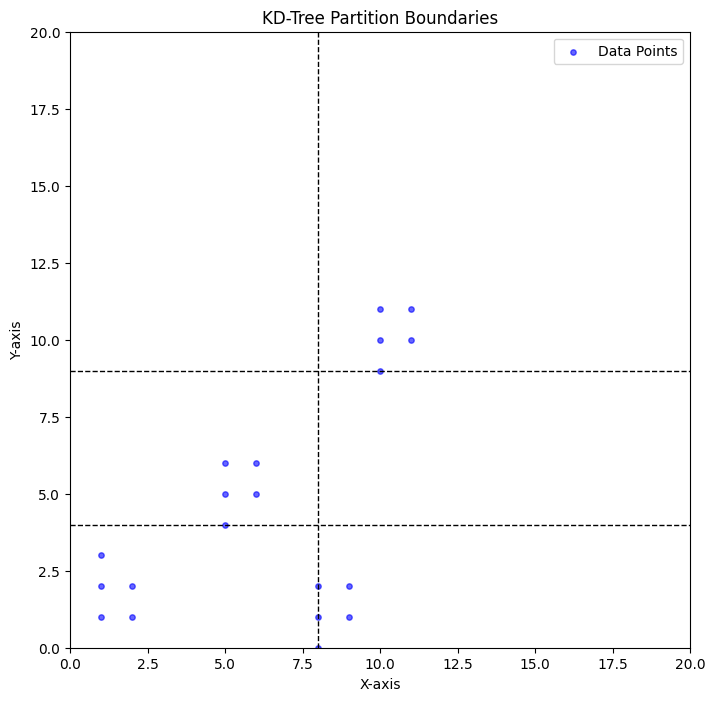

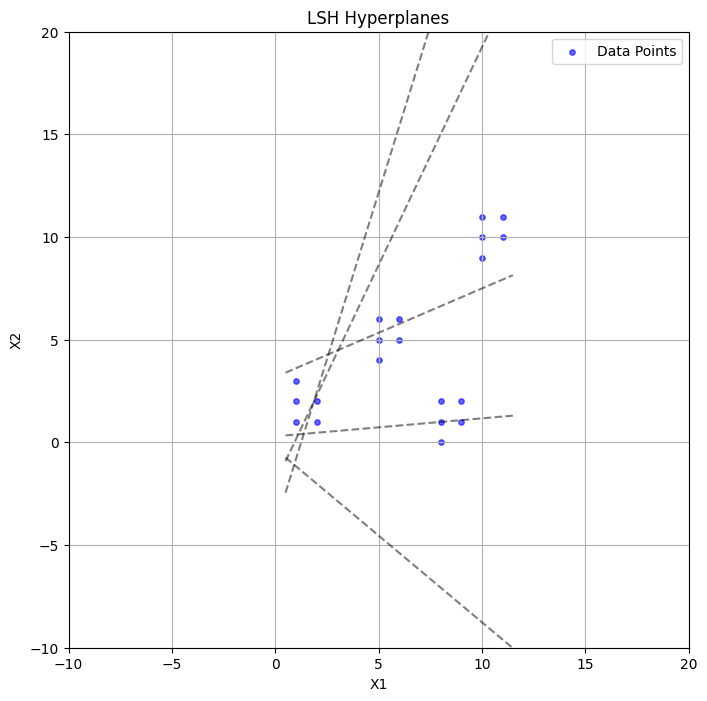

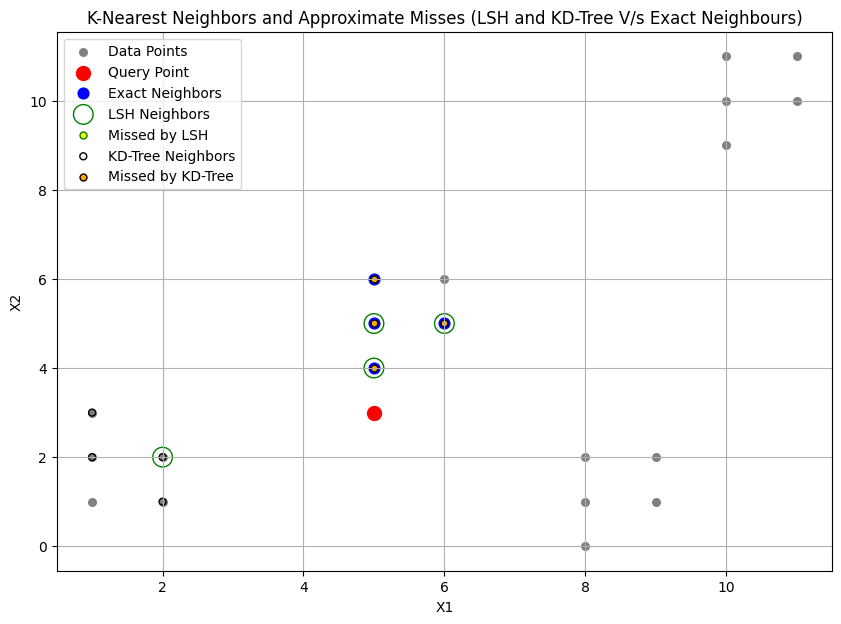

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(42)

def simulate_approximation(X, query_point, k, kdtree_model):
    exact_indices, _ = naive_knn(X, query_point, k)

    kdtree_results = kdtree_model.query(query_point, k)
    kdtree_points = [point for _, point in kdtree_results]
    kdtree_indices = [np.where(np.all(X == point, axis=1))[0][0] for point in kdtree_points]

    return exact_indices, kdtree_indices

def visualize_misclassifications(X, query_point, exact_indices, lsh_indices, kdtree_indices):
    plt.figure(figsize=(10, 7))

    plt.scatter(X[:, 0], X[:, 1], c='gray', s=30, label='Data Points')

    plt.scatter(query_point[0], query_point[1], c='red', s=100, label='Query Point')

    exact_points = X[exact_indices]
    plt.scatter(exact_points[:, 0], exact_points[:, 1], c='blue', s=60, label='Exact Neighbors')

    lsh_points = X[lsh_indices]
    missed_lsh = set(exact_indices) - set(lsh_indices)  # Ensure these are sets of integers
    plt.scatter(lsh_points[:, 0], lsh_points[:, 1], edgecolors='green', facecolors='none', s=200, label='LSH Neighbors')

    if missed_lsh:
        missed_points_lsh = X[list(missed_lsh)]
        plt.scatter(missed_points_lsh[:, 0], missed_points_lsh[:, 1], c='yellow', edgecolors='green', s=25, label='Missed by LSH')

    kdtree_points = X[kdtree_indices]
    missed_kdtree = set(exact_indices) - set(kdtree_indices)  # Ensure these are sets of integers
    plt.scatter(kdtree_points[:, 0], kdtree_points[:, 1], edgecolors='black', facecolors='none', s=25, label='KD-Tree Neighbors')

    if missed_kdtree:
        missed_points_kdtree = X[list(missed_kdtree)]
        plt.scatter(missed_points_kdtree[:, 0], missed_points_kdtree[:, 1], c='orange', edgecolors='black', s=25, label='Missed by KD-Tree')

    plt.legend()
    plt.title('K-Nearest Neighbors and Approximate Misses (LSH and KD-Tree V/s Exact Neighbours)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.show()


X_sample = np.array([
    [1, 1], [1, 2], [1, 3], [2, 1], [2, 2], # Cluster 1
    [5, 5], [5, 6], [6, 5], [6, 6], [5, 4], # Cluster 2
    [10, 10], [10, 11], [11, 10], [11, 11], [10, 9], # Cluster 3
    [8, 1], [8, 2], [9, 1], [9, 2], [8, 0], # Cluster 4
])

# Query point
query = np.array([5,3])
k = 4

lsh = LSH(num_hyperplanes=5, num_dimensions=2)
lsh.fit(X_sample)
lsh_indices,distances = lsh.query(query, k=k)
kdtree_model_sample = OptimizedKDTree(X_sample, max_samples_in_leaf=6)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_sample[:, 0], X_sample[:, 1], s=15, c='blue', alpha=0.6, label="Data Points")
kdtree_model_sample.plot_tree(ax, x_min=0, x_max=1, y_min=0, y_max=1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("KD-Tree Partition Boundaries")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_sample[:, 0], X_sample[:, 1], s=15, c='blue', alpha=0.6, label="Data Points")
lsh.plot_hyperplanes(ax)

ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("LSH Hyperplanes")
ax.legend()
plt.grid(True)
plt.show()

exact_idx, kdtree_idx = simulate_approximation(X_sample, query, k, kdtree_model_sample)

visualize_misclassifications(X_sample, query, exact_idx, lsh_indices, kdtree_idx)
